# Boundary reflection by conditional probability.

In the file, we are not longer using simple reflection algorithm. Instead, we save the particle's postion Z_n, and then one time increment of SDE scheme on these particles, then we get Z_{n+1}. If Z_{n+1} is outside the boundary, We throw away the Z_{n+1} and compute it one more time until it is inside the boundary. Idea is to ulltilise central limit theorem to achieve conditional probability in wiener process. 

* The best way to direction change normal distribution to conditional normal distribution. But it takes time to code. En easy way to verify the idea is, by central limit theorem, if I have enoungh particles, we will achieve conditional normal distribution when we reject impossible event such z<0, z>H. 

In [1]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
import matplotlib
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
%matplotlib inline
plt.style.use('bmh')

## Diffusivity profile

In [2]:
import sympy
z, w=sympy.symbols('z w')
H=1
a=1
Kbar = 1
prefactor = Kbar*2*(1+a)*(1+2*a)/(a**2*H**(1+1/a))

sym_dKdz_down   =  sympy.diff(prefactor*z*(H-2*z)**(1/a),  z, 1)
sym_d2Kdz2_down   =  sympy.diff(prefactor*z*(H-2*z)**(1/a),  z, 2)
sym_d3Kdz3_down   =  sympy.diff(prefactor*z*(H-2*z)**(1/a),  z, 3)

sym_dKdz_up     =  sympy.diff(prefactor* (H-z)*(2*z-1)**(1/a), z, 1)
sym_d2Kdz2_up   =  sympy.diff(prefactor* (H-z)*(2*z-1)**(1/a), z, 2)
sym_d3Kdz3_up   =  sympy.diff(prefactor* (H-z)*(2*z-1)**(1/a), z, 3)

dKdz_down   =  sympy.utilities.lambdify(z,          sym_dKdz_down,np)
d2Kdz2_down =  sympy.utilities.lambdify(z,          sym_d2Kdz2_down,np)
d3Kdz3_down =  sympy.utilities.lambdify(z,          sym_d3Kdz3_down,np)

dKdz_up   =  sympy.utilities.lambdify(z,          sym_dKdz_up,np)
d2Kdz2_up =  sympy.utilities.lambdify(z,          sym_d2Kdz2_up,np)
d3Kdz3_up =  sympy.utilities.lambdify(z,          sym_d3Kdz3_up,np)

#%%
#Some ultility function
# Pycnocline

def pycnocline(z):
    # See Gräwe et al. (2012)
    a = 1
    H = 1
    Kbar = 1
    prefactor = Kbar*2*(1+a)*(1+2*a)/(a**2*H**(1+1/a))
    G = prefactor*np.where(z < H/2, z*(H-2*z)**(1/a),
                           (H-z)*(2*z-1)**(1/a))
    return np.where((0.0 < z) & (z < 1.0), G, 0.0)
K=pycnocline

def pycnocline_down(z):
    a = 1
    H = 1
    Kbar = 1
    prefactor = Kbar*2*(1+a)*(1+2*a)/(a**2*H**(1+1/a))
    return prefactor*z*(H-2*z)**(1/a)
K_down=pycnocline_down

def pycnocline_up(z):
    a = 1
    H = 1
    Kbar = 1
    prefactor = Kbar*2*(1+a)*(1+2*a)/(a**2*H**(1+1/a))
    return prefactor*(H-z)*(2*z-1)**(1/a)
K_up=pycnocline_up

def dKdz(z):
    return np.where(z < H/2,  dKdz_down(z), dKdz_up(z))

def d2Kdz(z):
    return np.where(z < H/2, d2Kdz2_down(z),d2Kdz2_up(z))

def d3Kdz(z):
    return np.where(z < H/2, d3Kdz3_down(z),d3Kdz3_up(z))



## Lgrangian schemes

In [3]:
#%%

#######
#Euler#
#######

def step_e(z, H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    a=dKdz(z)
    b=np.sqrt(2*K(z))
    
    temp=z+a*dt+b*dW

    return temp

##########
#Milstein#
##########

def step_m(z,H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    dkdz=dKdz(z)
    b=np.sqrt(2*K(z))
    
    temp= z + (1/2)*dkdz*(dW*dW+dt) + b*dW
    return temp

########
#Visser#
########

def step_v(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    a = dKdz(z)
        
    b = np.sqrt(2*K(z + 1/2*a*dt))
    
    temp= z + a*dt + b*dW

    return temp    

##############
#Milstein 2nd#
##############

def step_m2(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)

    k=pycnocline(z)
    dkdz=dKdz(z)
    ddkdz=d2Kdz(z)
    dddkdz=d3Kdz(z)
    sqrt2k=np.sqrt(2*k)
    
    a = dkdz
    da = ddkdz
    dda = dddkdz
    b = sqrt2k 
    db = dkdz/b
    ddb = ddkdz/b - ((dkdz)**2)/b**3
    
    ab = da*b+a*db
    
    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2

    return temp



# The key is here.

In [25]:
def oneStep(Z, scheme, H, dt):
    
    z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    #The key is here, It act like a conditional probability such you can not have particle outside the boudnary.
    maskOutSide = ((H < Z) | (0 > Z))
    
    if (np.any(maskOutSide)):
        loop = True
    else:
        loop = False
    
    while (loop):
        somes = z_Origin[maskOutSide]
        somes = scheme(somes, H, dt, somes.size)
        Z[maskOutSide] = somes
        temp_mask = ((H < somes) | (0 > somes))
        maskOutSide[maskOutSide] = temp_mask
        
        if (np.any(temp_mask) == False):
            loop = False
            
    return Z

## Parallel functions

In [26]:
def parallelWiener(Tmax, dt, H, Testdepth, Np, Nbins,
                     queneEu, queneV, queneM, queneM2):
    np.random.seed()
    Ntime   =int(Tmax/dt)  
    
    zEul    = np.full((Np,),0.75)
    zVis    = np.full((Np,),0.75)
    zMil    = np.full((Np,),0.75)
    zMil2   = np.full((Np,),0.75)
    print("Np: ", Testdepth)

    for i in range(Ntime):

        zEul = oneStep( zEul,    step_e,         H, dt)
        oneStep( zVis,    step_v,         H, dt)
        oneStep( zMil,    step_m,         H, dt)
        oneStep( zMil2,   step_m2,        H, dt)
        
        if (i == Ntime-1):
            print(zEul)


        #Adding the histogram
        ###
        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    hist_E, _ = np.histogram(zEul, bins = np.linspace(0, Testdepth, Nbins))

    hist_V, _ = np.histogram(zVis, bins = np.linspace(0, Testdepth, Nbins))

    hist_M, _ = np.histogram(zMil, bins = np.linspace(0, Testdepth, Nbins))

    hist_M2, _ = np.histogram(zMil2, bins = np.linspace(0, Testdepth, Nbins))
            
    queneEu.put(hist_E)
    queneV.put(hist_V)
    queneM.put(hist_M)
    queneM2.put(hist_M2)
    
    return None
        
def RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter=Ntime

    if (__name__ == '__main__'):
        threads=[]
        
        queneEu=      mp.Queue()
        queneV=       mp.Queue()
        queneM=       mp.Queue()
        queneM2=      mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallelWiener, 
                                args= (Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                       queneEu, queneV, queneM, queneM2))
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_E      = np.zeros((Nbins-1,),'i')
    hist_V      = np.zeros((Nbins-1,),'i')
    hist_M      = np.zeros((Nbins-1,),'i')
    hist_M2     = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_E      += queneEu.get()
        hist_V      += queneV.get()
        hist_M      += queneM.get()
        hist_M2     += queneM2.get()


    #hist_E  = hist_E  / np.mean(hist_E)
    #hist_V  = hist_V  / np.mean(hist_V)
    #hist_M  = hist_M  / np.mean(hist_M)
    #hist_M2 = hist_M2 / np.mean(hist_M2)

    lists=[]
    lists.append(hist_E)
    lists.append(hist_V)
    lists.append(hist_M)
    lists.append(hist_M2)
    
    return lists

## Conditional probability method by rejection of Wiener process. 

In [27]:
Np        = 100
Nbins     = 500
Tmax      = 2          #Maximum time
dt        = 1e-3             #Delta time
H         = 1
Testdepth = 1
NumberOfThread = 1

startTime=time()
lists = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins)
endTime=time()
print("Time elapsed: ", endTime-startTime)

hist_E      = lists[0]
hist_V      = lists[1]
hist_M      = lists[2]
hist_M2     = lists[3]

Total number of process:  1
Np:  1
[0.30987482 0.10057065 0.62989998 0.42525259 0.06924366 0.12794213
 0.60813331 0.29690468 0.70360563 0.38613477 0.96175269 0.83309595
 0.54475171 0.14023474 0.4966314  0.45092965 0.83017277 0.44735845
 0.18548188 0.95020476 0.17482701 0.03315747 0.15137414 0.84517819
 0.71686313 0.74433189 0.94344241 0.28421386 0.86053763 0.44942114
 0.46044493 0.47735395 0.99649464 0.21633713 0.85656899 0.77875455
 0.04529974 0.68960521 0.05716424 0.63350448 0.17125324 0.54132535
 0.74159457 0.68785389 0.13236205 0.9517103  0.39255631 0.05403313
 0.08570435 0.93899831 0.32762685 0.22332797 0.57988315 0.70757085
 0.88280047 0.47718803 0.13120178 0.22502156 0.24710524 0.10772793
 0.88740987 0.215468   0.41744714 0.15213137 0.18084425 0.78088103
 0.21116149 0.81920092 0.22947899 0.53513885 0.05455215 0.41230982
 0.81862497 0.22445073 0.07355578 0.30097587 0.18878003 0.5101526
 0.94369071 0.68324688 0.69339904 0.90378222 0.75468766 0.15815537
 0.2605572  0.61407978 0.267

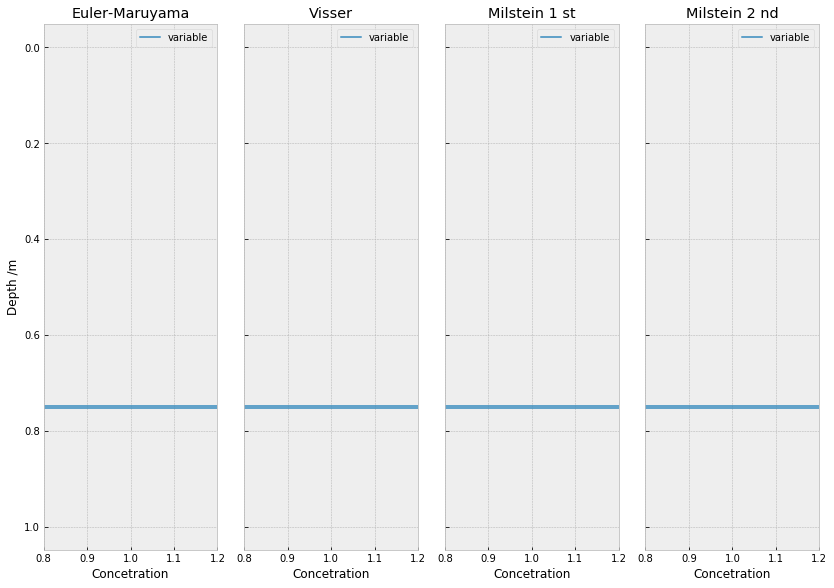

In [10]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27), sharey = True, sharex = True)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
ax[0].plot(hist_E, midpoints, linewidth=1.5, label= "variable")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('Euler-Maruyama')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(hist_V, midpoints, linewidth=1.5, label= "variable")
ax[1].set_xlabel('Concetration')
ax[1].set_title('Visser')
ax[1].legend()


ax[2].plot(hist_M, midpoints, linewidth=1.5, label= "variable")
ax[2].set_xlabel('Concetration')
ax[2].set_title('Milstein 1 st')
ax[2].legend()

ax[3].plot(hist_M2, midpoints, linewidth=1.5, label= "variable")
ax[3].set_xlabel('Concetration')
ax[3].set_title('Milstein 2 nd')
ax[3].set_xlim(0.8, 1.2)
ax[3].legend()

plt.tight_layout()
#plt.savefig("To_Tor1.png")

In [ ]:
Test    =np.random.uniform(0,H,400000)
hist, mindpoint = np.histogram(Test, bins = np.linspace(0, 1, 50))
hist = hist / np.mean(hist)
mindpoint = mindpoint[0:-1] + (mindpoint[1]-mindpoint[0])/2
plt.figure(figsize = (3,8.27))
plt.xlim(0.8, 1.2)
plt.gca().invert_yaxis()
plt.plot(hist, mindpoint)
plt.title("Initial histogram")
#plt.savefig("To_Tor2.png")

In [28]:
hist_E

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#Part 2 calculate Pmap
#Initialize variable

#sink velocity
w=0
#simulation time
Tmax=1      
#time step
dt=1e-4
#number of discrte time
Ntime=int(Tmax/dt)
#number of particles
Np=4000
#initial the postion array of all particle
z_e=np.zeros((Np,)) 
#Assign initial condition
z_e=np.full((Np,),0.75)
#copy initialized postion array to Milstein scheme
z_m=z_e.copy()
#copy initialized postion array to Milstein scheme
z_v=z_e.copy()
#copy initialized postion array to Milstein 2nd scheme
z_m2=z_e.copy()
#Set gap to 1 if you want histogram to recorde all the timestep.
Gap=4          
#Number of bins in the instogram
Nbins=200
#timer the performance of the whole program
start_time = time()
#print the Ntime
print("Ntime:  ", Ntime,"\n")
#create histogram
hist_E= np.zeros((1,Nbins-1))
hist_M= np.zeros((1,Nbins-1))
hist_V= np.zeros((1,Nbins-1))
hist_M2=np.zeros((1,Nbins-1))

#Running
###############
timeEuler=time()
print("Working with Euler Maruyama scheme")
for i in range(Ntime-1):
    z_e=step_e (z_e, 1,dt,Np)
    if ( i % Gap ==0):
        temp, _ = np.histogram(z_e, bins = np.linspace(0, 1, Nbins))
        temp=temp.reshape(1,Nbins-1)
        hist_E=np.concatenate((hist_E,temp), axis=0)
timeEuler=time()-timeEuler
print("TimeEuler: ", timeEuler,"\n")
###############
timeVisser=time()
print("Working with Visser scheme")
for i in range(Ntime-1):
    z_v=step_v (z_v,1,dt,Np)
    if ( i % Gap ==0):
        temp, _ = np.histogram(z_v, bins = np.linspace(0, 1, Nbins))
        temp=temp.reshape(1,Nbins-1)
        hist_V=np.concatenate((hist_V,temp), axis=0)
timeVisser=time()-timeVisser
print("TimeVisser: ", timeVisser,"\n")
###############
timeMilstein=time()        
print("Working with Misltein 1st scheme")
for i in range(Ntime-1):
    z_m=step_m (z_m,1,dt,Np)
    if ( i % Gap ==0):
        temp, _ = np.histogram(z_m, bins = np.linspace(0, 1, Nbins))
        temp=temp.reshape(1,Nbins-1)
        hist_M=np.concatenate((hist_M,temp), axis=0)
timeMilstein=time()-timeMilstein
print("TimeMilstein: ", timeMilstein,"\n")
###############
timeMilstein2=time()
print("Working with Milstein 2nd scheme")
for i in range(Ntime-1):
    z_m2=step_m2(z_m2, 1, dt,Np)
    if ( i % Gap ==0):    
        temp, _ = np.histogram(z_m2, bins = np.linspace(0, 1, Nbins))
        temp=temp.reshape(1,Nbins-1)
        hist_M2=np.concatenate((hist_M2,temp), axis=0)  
timeMilstein2=time()-timeMilstein2
print("TimeMilstein2: ", timeMilstein2,"\n")
###############
print("Time used: ", time()-start_time, "\n")
print("Done with calculation. you can enter the plotting section.")

In [ ]:
print("Plotting color map.")
#create number of position point that depends on number of bins
bins = np.linspace(0, 1, Nbins)
#right shift the position points
midpoints = bins[:-1]+(bins[1]-bins[0])/2
#create discrete time frame base on histogram. 
#"Please remember that we did not record every single time step og the simulation"
times = np.linspace(0, Tmax, hist_E.shape[0])

#Transpose these vector to use pcoloermesh from mathplotlib
hist_E= hist_E.T
hist_M= hist_M.T
hist_V= hist_V.T
hist_M2=hist_M2.T

#How many frame you want skip at beginning. We do this to show better contrast. 
frameSkip=5         

#plt.figure(1)
fig=plt.figure(1, figsize = (9,5))
ax=plt.gca()
cmap=ax.pcolormesh(times[frameSkip:], midpoints, hist_E[:,frameSkip:], cmap='jet')
fig.colorbar(cmap)
plt.xlabel("Time")
plt.ylabel("Depth")
plt.title("Euler Maruyama")
plt.tight_layout()
plt.grid(True)
#fil="../Figures/Euler_dt=%2.1e.png"%dt
#plt.savefig(fil)

#plt.figure(2)
fig=plt.figure(2, figsize = (9,5))
ax=plt.gca()
cmap=ax.pcolormesh(times[frameSkip:], midpoints, hist_M[:,frameSkip:], cmap='jet')
fig.colorbar(cmap)
plt.xlabel("Time")
plt.ylabel("Depth")
plt.title("Milstein 1st order")
plt.tight_layout()
plt.grid(True)
#fil="../Figures/Milstein_dt=%2.1e.png"%dt
#plt.savefig(fil)

#plt.figure(3)
fig=plt.figure(3, figsize = (9,5))
ax=plt.gca()
cmap=ax.pcolormesh(times[frameSkip:], midpoints, hist_V[:,frameSkip:], cmap='jet')
fig.colorbar(cmap)
plt.xlabel("Time")
plt.ylabel("Depth")
plt.title("Visser")
plt.tight_layout()
plt.grid(True)
#fil="../Figures/Visse_dt=%2.1e.png"%dt
#plt.savefig(fil)

#plt.figure(4)
fig=plt.figure(4, figsize = (9,5))
ax=plt.gca()
cmap=ax.pcolormesh(times[frameSkip:], midpoints, hist_M2[:,frameSkip:], cmap='jet')
fig.colorbar(cmap)
plt.xlabel("Time")
plt.ylabel("Depth")
plt.title("Milstein 2nd order")
plt.tight_layout()
plt.grid(True)
#fil="../Figures/Milstein2_dt=%2.1e.png"%dt
#plt.savefig(fil)

